# RCSJ Simulation including: RF drive, Shot & Johnson Noise, tunable C $\Phi$ R #
Simulate IV-curves using a Heun integrator for the stochhastic differential equation.

The main for-loop is translated to C for speed with help of Numba.

Parallel computation is possible for ensemble averaging via joblib.

To install the neccessary packages, copy the line to your (venv) command prompt:
  
pip install joblib tqdm matplotlib numpy numba

In [5]:
import numpy as np
import warnings
%matplotlib ipympl
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from numba import njit

def coth(x):
    """Compute hyperbolic cotangent using cosh/sinh."""
    return np.nan_to_num(np.cosh(x) / np.sinh(x),nan=0,neginf=0,posinf=0)

@njit
def rsj_heun_run_numba(gammaDC, gammaAC, Omega, beta_c,
                       phi0, v0, tSim, dt,
                       noiseAmp, frac_4pi):
    """
    Integrate dimensionless RCSJ with a Heun (explicit trapezoidal) method using Numba.
    Numba: The Phython for Loop is translated to C for speed.

    The equations (dimensionless) are:
        dphi/dtau = v
        dv/dtau   = gammaDC + gammaAC*sin(Omega*tau)
                    - [ (1-frac_4pi)*sin(phi) + frac_4pi*sin(phi/2) ]
                    - (1/beta_c)*v + noiseAmp*randn*sqrt(dt)
    """

    N = int(np.floor(tSim / (Omega*dt)))
    tau_array = np.arange(N+1)*dt
    phi_array = np.zeros(N+1)
    v_array   = np.zeros(N+1)

    # Set initial conditions
    phi_array[0] = phi0
    v_array[0]   = v0

    for i in range(N):
        phi_n = phi_array[i]
        v_n   = v_array[i]
        tau_n = tau_array[i]

        # Wiener increment:
        dW = np.random.randn() * np.sqrt(dt)

        # Compute drift at old state
        fphi_n = v_n
        fv_n   = (gammaDC
                  + gammaAC*np.sin(Omega*tau_n)
                  - ((1.0 - frac_4pi)*np.sin(phi_n) + frac_4pi*np.sin(phi_n/2.0))
                  - (1.0/beta_c)*v_n)

        # Predictor step (Euler)
        phi_star = phi_n + fphi_n * dt
        v_star   = v_n   + fv_n   * dt + noiseAmp*dW

        # Evaluate drift at predicted state
        tau_star  = tau_n + dt
        fphi_star = v_star
        fv_star   = (gammaDC
                     + gammaAC*np.sin(Omega*tau_star)
                     - ((1.0 - frac_4pi)*np.sin(phi_star) + frac_4pi*np.sin(phi_star/2.0))
                     - (1.0/beta_c)*v_star)

        # Corrector
        phi_array[i+1] = phi_n + 0.5*(fphi_n + fphi_star)*dt
        v_array[i+1]   = v_n   + 0.5*(fv_n   + fv_star)*dt + noiseAmp*dW

    return tau_array, phi_array, v_array

def rcsj_iv_curve(R, C, T, Ic, f_drive, gammaAC,
                  tSim, dt, ensembleRuns, discard_fraction,
                  gammaDC_vals, frac_4pi):
    """
    scanning over DC bias currents, doing multiple ensemble runs with the Heun integrator,
    and updating the average voltage + noise amplitude at each step.
    """
    # Physical constants
    e    = 1.602176634e-19
    hbar = 1.054571817e-34
    kB   = 1.380649e-23

    phi0 = 0.0
    v0   = 0.0
    noiseAmp = 0.0

    Ncurrents = len(gammaDC_vals)
    Vavg = np.zeros(Ncurrents)

    beta_c = (2.0* e * Ic * (R**2) * C)/hbar
    print(f"Stewart-McCumber parameter, beta_c = {beta_c:.3f}")

    omega_p = np.sqrt( (2.0*e*Ic)/(hbar*C) )
    print(f"Plasma frequency = {omega_p/(2.0*np.pi*1e9):.3f} GHz")

    omega_drive = 2.0*np.pi * f_drive
    print(f"Microwave drive frequency = {omega_drive/(2.0*np.pi*1e9):.3f} GHz")

    Omega = omega_drive/omega_p if f_drive != 0.0 else 1.0
    print(f"Dimensionless drive frequency, Omega = {Omega:.3f}")

    EJ = (hbar*Ic)/(2.0*e)
    print(f"Josephson energy, EJ = {EJ/e:.3f} eV")

    loop_iter = tqdm(range(Ncurrents), desc="Simulating DC biases")

    for k in loop_iter:
        gammaDC = gammaDC_vals[k]

        def single_run(_):
            tau_, _, vVals = rsj_heun_run_numba(gammaDC, gammaAC, Omega, beta_c,
                                                phi0, v0, tSim, dt,
                                                noiseAmp, frac_4pi)
            idxStart = int(np.floor(discard_fraction*len(tau_)))
            steady_v = vVals[idxStart:]
            return np.mean(steady_v)

        results = Parallel(n_jobs=-1)(delayed(single_run)(r) for r in range(ensembleRuns))

        Vavg[k] = np.mean(results)
        v0 = Vavg[k]

        # compute new noise amplitude from the new average voltage
        if v0 <= 0.0:
            noiseAmp = 0.0
        else:
            S = 2.0*e*v0/R * coth( e*v0/(2.0*kB*T) )
            noiseAmp = np.sqrt( 2.0*S/(Ic**2 * omega_p * dt) )

    return Vavg, Omega

In [6]:
# The "experimental" parameters:
R       = 120 #Ohm
C       = 5e-14 #Farad
T       = 0.080 #Kelvin
Ic      = 0.4e-6 #Ampere
f_drive = 5e9 #Hz
gammaAC = 0.2 #I_AC/I_c
gammaDC_vals = np.linspace(0.6,1.6,200) #I_DC/I_c
frac_4pi = 0.2  # fraction of 4pi-periodicity of current-phase-relation
                # ((1.0 - frac_4pi)*np.sin(phi) + frac_4pi*np.sin(phi/2.0))

# Simulation parameters
tSim           = 300  # simulation time in multiples of the plasma frequency period of the AC drive
dt             = 0.0005 # simulation time increment in dimensionaless units
ensembleRuns   = 8 # No. of samples for average for each I-V point
discard_fraction = 2/3 # discarded percentage of simulated V-t curve

In [7]:
Vavg, Omega = rcsj_iv_curve(R, C, T, Ic, f_drive, gammaAC,
                            tSim, dt, ensembleRuns,
                            discard_fraction, gammaDC_vals, frac_4pi)

Stewart-McCumber parameter, beta_c = 0.875
Plasma frequency = 24.814 GHz
Microwave drive frequency = 5.000 GHz
Dimensionless drive frequency, Omega = 0.201
Josephson energy, EJ = 0.001 eV


Simulating DC biases:  25%|██▌       | 50/200 [00:18<00:57,  2.63it/s]C:\Users\Franz\AppData\Local\Temp\ipykernel_14356\762085981.py:11: RuntimeWarning: overflow encountered in cosh
  return np.nan_to_num(np.cosh(x) / np.sinh(x),nan=0,neginf=0,posinf=0)
C:\Users\Franz\AppData\Local\Temp\ipykernel_14356\762085981.py:11: RuntimeWarning: overflow encountered in sinh
  return np.nan_to_num(np.cosh(x) / np.sinh(x),nan=0,neginf=0,posinf=0)
C:\Users\Franz\AppData\Local\Temp\ipykernel_14356\762085981.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan_to_num(np.cosh(x) / np.sinh(x),nan=0,neginf=0,posinf=0)
Simulating DC biases: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


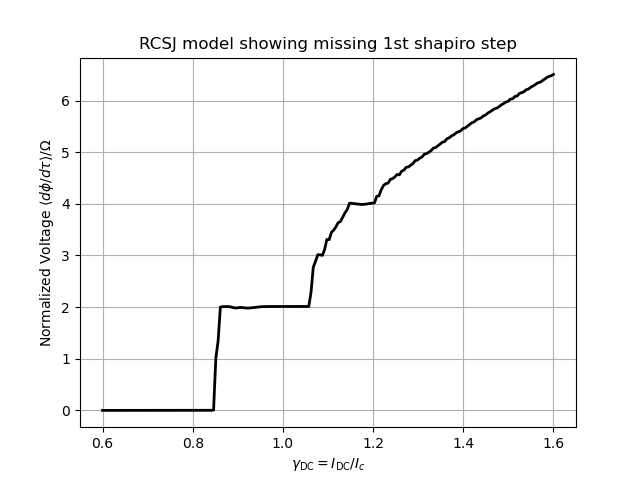

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [ ]:
# Plot
plt.figure()
plt.plot(gammaDC_vals, Vavg/Omega, 'k', linewidth=2)
plt.xlabel(r'$\gamma_{\mathrm{DC}} = I_{\mathrm{DC}} / I_{c}$')
plt.ylabel(r'Normalized Voltage $\langle d\phi/d\tau\rangle / \Omega$')
plt.title('RCSJ model showing missing 1st shapiro step')
plt.grid(True)
plt.show()